# Introduction to statistics in Python

This notebook is intended to introduce you to concepts and techniques of statistical computing in Python. It is assumed that you are familiar with numerical computing using `numpy` and plotting using `matplotlib`. If you are not comfortable with these topics see the notebook `Intro to numerics.ipynb`.

As you read through this notebook you might see __functions and classes that you may not have seen before__. While the notebook tries to show you how they are used, you are encouraged to __read relevant documentation__ to understand what they do, and/or play around with them by __creating new cells__ (or a new notebook if you don't want to careful about overwriting variables). Here are links to documentation for [numpy and scipy](https://docs.scipy.org/doc/numpy/reference/), and [matplotlib](https://matplotlib.org/contents.html).

For deeper information about statistics and related physics, <font color="red">see the following textbooks:</font> and take the statistical mechanics (112) and data analsysis (188) courses.

### Contents
- [First look at fitting](#fit1)
- [Sampling random numbers](#draw)
- [Estimating moments](#moments)
- [Histograms](#hist)
- [Hypothesis testing](#chi)
- [Central limit theorem](#clt)
- [Gaussian distributions](#gauss)
- [Bayesian inference](#bayes)
- [Fitting revisited](#fit2)
- [Fisher information](#fisher)

In [1]:
import numpy as np #see the notebook "Intro to Python.ipynb" if you don't know what NumPy is.
from matplotlib import pyplot as plt #see the notebook "Intro to numerics.ipynb" if you don't know what matplotlib is.

%matplotlib inline
#magic function that sets the plots to display inline

<a name="fit1"></a>
### Fitting

A common problem, particularly in experimental physics, is fitting some data $\{(x_i,y_i)\}$ to a theoretical curve $f(x)$, which depends on some parameters $\theta$. This amounts to choosing parameters to best explain the data. The most common approach is to define a loss function $L(\theta)$, which quantifies how far away the data is from the theoretical predictions, and choose the $\theta$ that minimises $L$, i.e. $\overline\theta={\rm argmin}_\theta\:L(\theta)$. This is called optimising $L$ over $\theta$. When one is at a _local_ minimum (maximum) of a function, any variations would increase (reduce) the function value, so we have $$\left.\frac{dL}{d\theta}\right|_{\theta=\theta_{\rm opt}}=0,$$ and since we are minimising $L$ the second derivative at the optimum value must be positive. However, finding the _global_ minimum/maximum can be a difficult task.

Optimisation is a universal problem. All of physics comes from the optimisation of the action. Evolution is the natural optimisation of life's ability to survive. A similar thing applies to businesses in the free market, which optimise profit. The philosophy of utilitarianism is based on the assumption that people have utility functions over which they optimise their decisions. In this view, life is nothing but a series of choices in which we are forced to optimise over our given utility functions, and this is indeed the philosophy on which concepts such as social utility and government are built. Neural networks are able to learn by optimising internal parameters in response to external input; perhaps we also learn in a similar way. Needless to say, optimisation is a rich and lucrative field of study in mathematics and computer science.

A common choice for $L(\theta)$ is the squared difference between the expected and measured data points, $$L(\theta) = \sum_i\big(y_i-f(x_i,\theta)\big)^2.$$ This is called _least squares regression_. If the fitting function is linear in the parameters, e.g. for polynomial fitting $f(x,\theta) = \sum_{n=0}^d\theta_nx^n$, then the loss function is convex, which guarantees that a local minimum is a global minimum, so one simply has to solve $\frac{d L}{d\theta_n}=0$. This is a linear problem, so can be solved by inverting a matrix (whose size is the number of data points). In Python, you could use `numpy.polyfit()`, `numpy.linalg.lstsq()`, `numpy.Polynomial.fit()`, or any other implementation.

476

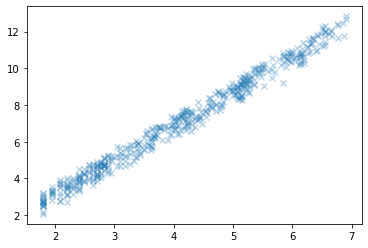

In [2]:
x, y = np.load("mystery_array.npy")
plt.scatter(x, y, marker="x", alpha=0.3) #alpha is transparency
len(x)

In [3]:
def loss(fn, theta, x, y):
    predicted = fn(x, *theta)
    return np.sum((y - predicted)**2)

array([ 1.87683927, -0.62978655])

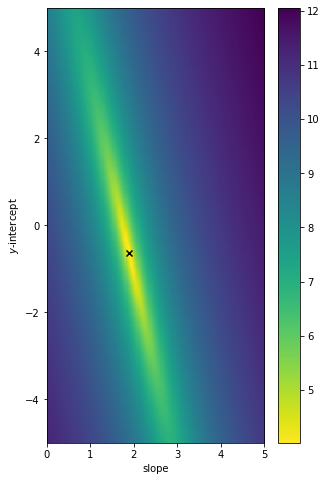

In [4]:
linear = lambda x, t0, t1: x*t0 + t1

extent = [0,5,-5,5] #plotting range in format [x_min, x_max, y_min, y_max]
m = np.linspace(*extent[:2],200)
y0 = np.linspace(*extent[2:],200)

losses = np.array([[loss(linear, (slope,intercept), x, y) for slope in m] for intercept in y0])
p = np.polyfit(x,y,1) #find best-fit params
#new best practice is to use np.polynomial.Polynomial.fit(x,y,1).convert().coef[::-1]

plt.figure(figsize=((extent[1]-extent[0]),0.8*(extent[3]-extent[2]))) #calculate appropriate figsize (including colourbar)
plt.imshow(np.log(losses), extent=extent, origin="lower", cmap="viridis_r") #plot log-loss with reversed cmap
plt.colorbar()
plt.scatter(*p, marker="x", c="k")
plt.xlabel("slope")
plt.ylabel("$y$-intercept")

p

476

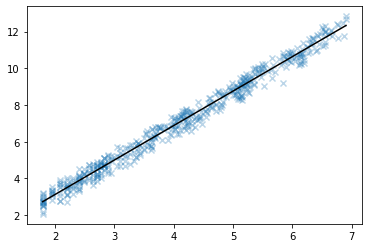

In [5]:
plt.scatter(x,y,marker="x",alpha=0.3)
bounds = np.array([np.amin(x),np.amax(x)])
plt.plot(bounds, bounds*p[0]+p[1], c="k")
len(x)

A common model for a wide variety of physics quantities is a _power-law_, $f(x)\propto x^\alpha$, where the exponent is a physically relevant parameter that is to be fit. In this case, we can use a linear fitting function in log-space. In fact, the data in `mystery_array.npy` has already been transformed to log-space, as can be confirmed by transforming back.

In [6]:
ey,ex = np.exp(y), np.exp(x)
ex[:20], ey[:20] #note that they're all integers

(array([179., 184., 216., 126., 288., 389., 196., 248., 396., 172., 270.,
        484., 422., 191., 344., 364., 460., 324., 162.,  33.]),
 array([13942.,  9754., 15748.,  3593., 12743., 48326., 10266., 25585.,
        56286.,  3843., 19185., 42093., 33015.,  6170., 50245., 23625.,
        48247., 36509.,  7915.,   330.]))

The most common type of non-linear optimisation algorithm is gradient descent, in which one iteratively updates the guess in the direction opposite to the gradient, similarly to Newton's method. For an example of non-linear optimisation, let's explicitly fit the data to a power law using the [`scipy.optimize` module](https://docs.scipy.org/doc/scipy-0.19.0/reference/optimize.html).

array([ 2.0773123 , -1.79912823])

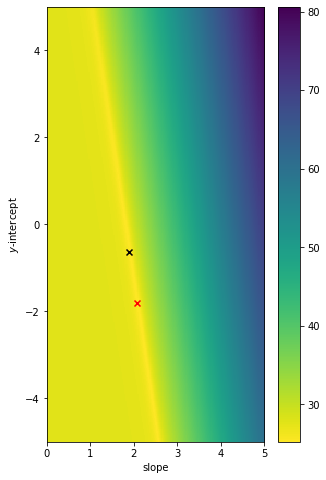

In [7]:
from scipy.optimize import curve_fit

power_law = lambda x, t0, t1: np.exp(t1)*x**t0

losses = np.array([[loss(power_law, (slope,intercept), ex, ey) for slope in m] for intercept in y0])
p2 = curve_fit(power_law, ex, ey)[0] #find best-fit params

plt.figure(figsize=((extent[1]-extent[0]),0.8*(extent[3]-extent[2])))
plt.imshow(np.log(losses), extent=extent, origin="lower", cmap="viridis_r")
plt.colorbar()
plt.scatter(*p, marker="x", c="k")
plt.scatter(*p2, marker="x", c="r")
plt.xlabel("slope")
plt.ylabel("$y$-intercept")

p2

The result we get is different from the linear fit in log-space! Let's plot both.

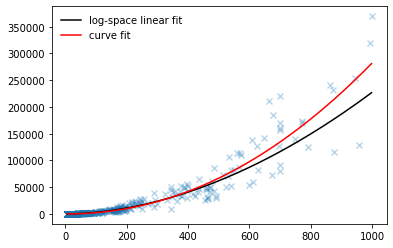

In [8]:
plt.scatter(ex, ey, marker="x", alpha=0.3)

xmesh = np.linspace(np.amin(ex),np.amax(ex),1000)
plt.plot(xmesh, np.exp(p[1])*xmesh**p[0], c="k", label="log-space linear fit")
plt.plot(xmesh, np.exp(p2[1])*xmesh**p2[0], c="r", label="curve fit")
plt.legend(frameon=False)

#plt.xscale("log");plt.yscale("log") #uncomment this line (the semicolon acts as a line break)

The difference between the two fits is that the one in log-space gives more importance to measurements with low-magnitude `y` values than the raw data. This may or may not be desirable depending on the specific applications. We will return to fitting once we have developed tools for you to really understand what's going on here.

A related task to fitting is _interpolation_, in which we approximate a function based on some samples. Interpolation can be useful to approximate a function that is difficult to evaluate, smoothen data, or to obtain better looking graphics. A common choice for interpolation is to approximate the samples using a piecewise polynomial, known as a _spline_. For "smooth" functions, we'd expect the spline to be at least twice diffferentiable, which means the polynomials must be at least cubic. While we don't show you how to use the tools here, there are several interpolation tools in the [`scipy.interpolate` module](https://docs.scipy.org/doc/scipy/reference/interpolate.html), and the documentation is rather straightforward. <font color="red">Should I give an example?</font>

<a name="draw"></a>
### Sampling random numbers

Computers are deterministic. A program will run will always run the same way from the same initial state. However, there are several algorithms that, given an initial number, return a series of numbers that are difficult to predict, and are effectively random. These are called pseudo-random number generators, also referred to as random number generators (RNGs). Random numbers have a variety of uses, from security/cryptography to video games to solving problems by simulating stochastic systems. There are algorithms that claim to provide "true" randomness, usually based on some physical measurement, but whether or not something is truly random is a matter of lengthy debate. For most applications we simply require numbers that roughly evenly sample some target space and are free of the particular types of correlation that would interfere with our specific application. Python has a `random` suite built-in, but we shall use the `numpy.random` module.

In [9]:
np.random.rand(5) #random floats between 0 and 1
#try running this a few times

array([0.28849365, 0.63838826, 0.02037123, 0.60893323, 0.46198199])

The determinism of computers can also be useful as it enables reproducability. By explicitly setting a _seed_, which determines all the random numbers generator after seeding and before re-seeding, we can ensure that we can reproduce the exact same sequence of "random numbers" if required. This is useful while debugging, and when cross-checking someone else's methods. Therefore, it is considered good practice to explicitly seed all the RNGs you use, especially if you are sharing the code or results produced from it.

Since the state of the `numpy` RNG is represented by a 32-bit integer, the seed must be an integer that is less than $2^{32}$. If you don't explicitly set a seed, the RNG will typically be initialised using the clock time or some other "random" source.

In [10]:
np.random.seed(13486313) #try changing this and running a few times
np.random.rand(5)

array([0.27284743, 0.12675587, 0.61558288, 0.52897539, 0.73999208])

You can draw from common distributions using functions in the [`numpy.random` module](https://docs.scipy.org/doc/numpy/reference/routines.random.html). Typically these samples are generated from uniformly distributed samples by applying a transformation. If you'd like to draw samples from an arbitrary probability distirbution, there are various techniques that enable you to do that, including transforming variables, rejecting certain values, re-weighting samples, etc. <font color="red">Provide link?</font>

If you'd like to draw from discrete distributions, you would typically use a uniform deviate and assign intervals to each outcome. For uniform sampling of integers you can use `numpy.random.randint()` and for general non-uniform discrete probabilities, you can use `numpy.random.choice()`.

In [11]:
np.random.randint(100, size=10)

array([31, 26, 80, 14, 18, 57,  9, 10, 45, 66])

<a name="moments"></a>
### Estimating moments

Estimating the statistical moments of a distribution from a sample is easy:

In [12]:
def mean(array):
    return np.sum(array)/len(array)

def standard_deviation(array):
    return (np.sum(array**2)/len(array)-mean(array)**2)**.5

In [13]:
x = np.random.rand(500)
%time mean(x), standard_deviation(x)

CPU times: user 76 µs, sys: 31 µs, total: 107 µs
Wall time: 113 µs


(0.5087495725567253, 0.2831962157826845)

These functions (and more) are already built-in to numpy.

In [14]:
%time np.mean(x), np.std(x)

CPU times: user 200 µs, sys: 84 µs, total: 284 µs
Wall time: 292 µs


(0.5087495725567253, 0.2831962157826846)

You might notice that the output of `np.std()` differs from that of our `standard_deviation()` implementation. This is because we haven't included Bessel's correction which increases the estimate of variance by a factor of $\frac{N}{N-1}$ to account for the fact that the variance estimate only involves $N-1$ degrees of freedom since one is used to estimate the mean. (This is neglibile for large $N$.)
 
Analytically, $\langle x \rangle =\int_0^1 x\:dx=\frac{1}{2}$ and $\langle x^2 \rangle =\int_0^1 x^2\:dx=\frac{1}{3}$, so the uniform distribution between 0 and 1 has mean $\frac{1}{2}$ and standard deviation $\sqrt{\frac{1}{12}}\approx 0.289$. Here, we estimated the answer using our drawn pseudo-random numbers. Techniques that estimate quantities by sampling random numbers are known as _Monte Carlo_ techniques since they gamble to find the answer. Monte Carlo techniques are especially useful when analytic solutions are unknown or expensive to compute. 

How many points do we need to sample to get an accurate estimate of the mean and standard deviation?

Text(0.5, 0, 'number of samples')

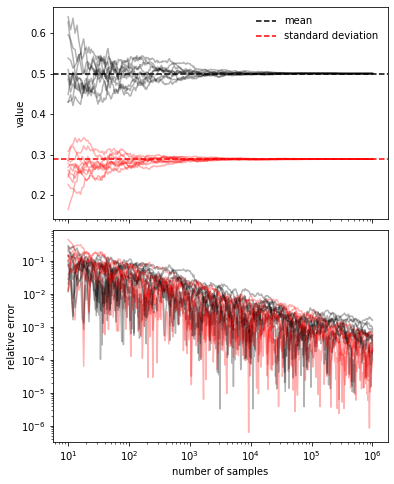

In [15]:
np.random.seed(875309) #try running this cell for a few different seeds

n = 500 #number of points on each line
nlines = 10
Ns = np.logspace(1, 6, n, dtype=int)

f, ax = plt.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0.05}, figsize=(6,8))
#2 plots: one for value and other for error, with same x-axis

for i in range(nlines):
    sims = np.random.rand(int(Ns[-1])) #sample random numbers

    #compute means, variances of the first N sample (for various Ns)
    means = np.array([mean(sims[:N]) for N in Ns])
    devs = np.array([np.std(sims[:N]) for N in Ns])

    #plot values
    ax[0].plot(Ns, means, c="k", alpha=0.3)
    ax[0].plot(Ns, devs, c="r", alpha=0.3)
    
    #plot errors
    ax[1].plot(Ns, np.abs(means*2-1), c="k", alpha=0.3)
    ax[1].plot(Ns, np.abs(devs*12**.5-1), c="r", alpha=0.3)

#add theoretical expectations as horizontal dashed line 
#across entire axis (doesn't need x-values, only a y-value)
ax[0].axhline(y=0.5, c="k", label="mean", ls="--")
ax[0].axhline(y=12**-0.5, c="r", label="standard deviation", ls="--")

ax[0].set_xscale("log")
ax[0].set_ylabel("value")
ax[0].legend(frameon=False)

ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_ylabel("relative error")
ax[1].set_xlabel("number of samples")

We can do a best-fit here, but we shall return to it later.

<a name="hist"></a>
### Histograms

Histograms are an effective way of visualising distributions. Histograms split the domain into discrete intervals called _bins_ and display the counts, i.e. the number of samples, that fall in each bin. The effectiveness of a histogram is very sensitive to the binning chosen, and this choice is often a tradeoff between resolution and randomness, since for finer binning resolutions the bin counts become more random (i.e. the standard deviation becomes larger compared to the mean). Here is a histogram of 500 "uniformly distributed" samples from the numpy RNG.

(array([43., 64., 38., 53., 50., 47., 48., 41., 52., 64.]),
 array([3.51427208e-04, 1.00286000e-01, 2.00220573e-01, 3.00155145e-01,
        4.00089718e-01, 5.00024290e-01, 5.99958863e-01, 6.99893436e-01,
        7.99828008e-01, 8.99762581e-01, 9.99697154e-01]),
 <a list of 10 Patch objects>)

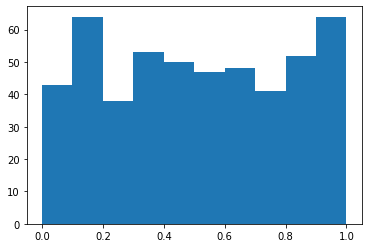

In [16]:
plt.hist(np.random.rand(500)) #10 bins by default
#notice it returns a 3-tuple containing the counts, the bin edges, and the actual plotted rectangle objects
#try running it a few times: it is random

Above, we use `matplotlib.pyplot.hist()` to directly plot a histogram from samples. To only compute the bins and counts, use `numpy.histogram()` or `scipy.stats.binned_statistic()`. 

In a histogram, each bin has a probability $p=\int_{\rm bin}\rho(x)\:dx$ of receiving each sample (for small bins this can be approximated to $p\approx V_{\rm bin}\rho(x_{\rm bin})$). If the samples are independent, the total number of counts in each bin is given by a binomial distribution. In the following histogram we've added lines indicating the expected number of counts in each bin, as well as the region that is within 1 standard deviation of the mean (for Gaussian probability distributions, this is called 1-$\sigma$).

In [17]:
np.random.seed(3332345) #run it a few times with different seeds

#play around with these
N=1000
nbins=20

samples = np.random.rand(N)
plt.hist(samples, bins=nbins) #set the bin edges or the number of bins using the bins keyword

p = 1/nbins #probability of each sample going in each bin
m = N*p #mean of counts in each bin (binomial dist)
s = (N*p*(1-p))**.5 #standard deviation of counts in each bin

plt.axhline(m, c="r")
plt.axhline(m+s, c="r", ls="--", alpha=0.5)
plt.axhline(m-s, c="r", ls="--", alpha=0.5)
plt.axhspan(m-s, m+s, color="r", alpha=0.25) #colour the range between two x-values

To verify that the probability distribution of the counts of each bin is indeed the binomial distribution, we draw `N1` samples from the uniform distribution, bin them into `nbins` bins and track the counts we see in a randomly chosen bin for `N2` trials. Again, the frequency of each bin is probabalistic, and is described by a binomial distribution, and again we plot the theoretical expectations. (However, the noise can be very low compared to the signal for large `N2`.) For large `N1/nbins` you might notice that the binomial distribution looks like a Gaussian.

Text(0, 0.5, 'number of counts')

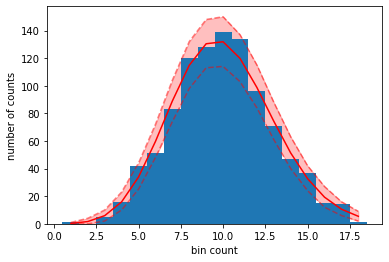

In [18]:
from scipy.stats import binom #binomial distribution object (see docs)

#np.random.seed(958643)

#try playing around with these three values (make it interactive if you want)
N1 = 100 #number of samples in original histogram
N2 = 1000 #number of samples in final histograms (number of initial histograms)
nbins = 10 #number of bins in initial histogram (since counts are discrete, bin width of final histogram is 1)

i = np.random.randint(nbins) #randomly choose which bin to plot distribution of
edges = np.linspace(0,1,nbins+1) #keep same bin edges for each sample
counts = np.zeros(N2, dtype=int)
for j in range(N2):
    counts[j] = np.histogram(np.random.rand(N1), edges)[0][i]
    #np.histogram() returns tuple of counts and edges, we only extract the count we want

count_mesh = np.arange(np.amin(counts), np.amax(counts)+1) #create mesh of counts in relevant range
bin_edges = np.arange(np.amin(counts)-0.5, np.amax(counts)+1) #bin edges centred on integer counts

plt.hist(counts, bin_edges)

theo_probs = binom.pmf(count_mesh, N1, 1/nbins) #theoretical probability of each count
exp = theo_probs*N2 #mean of each bi
lower, upper =  binom.interval(.9, N2, theo_probs)
#90% confidence intervals of each bin, better than using std dev for small bin counts

plt.plot(count_mesh, exp, c="r") #plot theoretical expectations
plt.plot(count_mesh, lower, ls="--", c="r", alpha=0.5)
plt.plot(count_mesh, upper, ls="--", c="r", alpha=0.5)
plt.fill_between(count_mesh, lower, upper, color="r", alpha=0.25) #colours area between lines

plt.xlabel("bin count")
plt.ylabel("number of counts")
#plt.yscale("log") #try out the log-scale

<a name="chi"></a>
### Hypothesis testing

One statistic that is sometimes used to test whether a histogram (or any other set of categorical, independent data) was sampled from a hypothetical distribution is the $\chi^2$ statistic, $$\chi^2=\sum_{i=1}^k\frac{(N_i-E_i)^2}{E_i},$$ where $N_i$ and $E_i$ are the observed and expected counts for each of the $k$ categories. If the data is indeed sampled from the hypothetical distribution, called the _null hypothesis_, then the probability distribution of the $\chi^2$ statistic converges to a $\chi^2$ distribution with $k-1$ degrees of freedom (since $N=\sum_iN_i$ is fixed) in the limit of infinite data. Given some data one can test the null hypothesis by comparing the $\chi^2$ statistic to the corresponding distribution and obtaining a $p$-value. A $p$-value essentially describes the probability of seeing a value greater than the observed one, so should be uniformly distributed between 0 and 1 if the hypothesis is true. For a really strong rejection, we'd need a $p$-value very close to 0 or 1, and the probability of a false rejection is (heuristically) $2\min(p,1-p)$. <font color="red">Add links for $\chi^2$, $p$-values?</font>

In the following cell we'll apply the $\chi^2$ test to the above cell, to test whether the count of a bin in a histogram really follows a binomial distribution. <font color="red">Should we keep it simple and test whether the smapling is uniform instead?</font> We'll do this `N3` times to obtain `N3` $\chi^2$ values, which we will compare to a $\chi^2$ distribution, obtaining `N3` $p$-values, which we compare to the uniform distribution. The [`scipy.stats` module](https://docs.scipy.org/doc/scipy/reference/stats.html) has a `chisquare()` function for testing as well as a `chi2` class for using the distribution.

In [19]:
from scipy.stats import chisquare #see docs

#np.random.seed(958643)

#try playing around with these three values (make it interactive if you want)
N1 = 20 #number of samples in original histogram
N2 = 1000 #number of samples in final histograms (number of initial histograms)
         #the chi^2 distribution describes the statistic in the limit N2 -> inf
nbins = 3 #number of bins in initial histogram (since counts are discrete, bin width of final histogram is 1)
N3 = 500 #number of chi^2 tests to run
k = 10 #bins for chi^2 test

i = np.random.randint(nbins) #randomly choose which bin to plot distribution of
edges = np.linspace(0,1,nbins+1) #keep same bin edges for each sample
counts = np.zeros((N3,N2), dtype=int)
for j in range(N3):
    for l in range(N2):
        counts[j,l] = np.histogram(np.random.rand(N1), edges)[0][i] #returns tuple of counts and edges, we only extract the count we want

#find reasonable bounds for the binning: 3-sigma or min/max, whichever one's tighter
m,s = np.mean(counts), np.std(counts)
lower = max(m-3*s, np.amin(counts))
upper = min(m+3*s, np.amax(counts))

#bin the data into the categorical distribution of which we can compute the chi^2 statistic
count_edges = np.linspace(lower, upper, k+1)
count_edges[0], count_edges[-1] = -np.inf, np.inf
observed_counts = np.zeros((N3,k), dtype=int)
for j in range(N3):
    observed_counts[j] = np.histogram(counts[j], bins=count_edges)[0]

expected_counts = binom.cdf(count_edges, N1, 1/nbins) #probability of each bin
expected_counts = expected_counts[1:]-expected_counts[:-1]
expected_counts *= N2
print(expected_counts) #to check if binning is ok

c, p = chisquare(observed_counts, expected_counts, axis=-1)
print(c[:10],p[:10])

[  3.30801526  14.28461134 133.91823133 145.70303568 182.1287946
 182.1287946  246.63274269  54.25920339  24.66327427  12.97329683]
[ 4.35370198 12.04243255 12.66285126  9.79924352  8.7667217   6.25036605
  7.18754121 16.39582448  9.5840027  12.19410844] [0.88663017 0.21092772 0.17846462 0.36698086 0.45908068 0.71462261
 0.61760072 0.05906191 0.38519921 0.20258632]


Text(0, 0.5, 'number of counts')

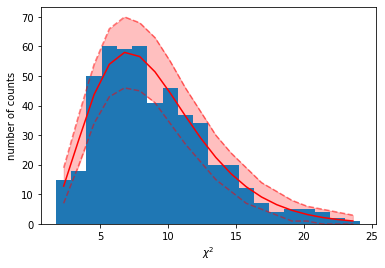

In [20]:
from scipy.stats import chi2

nbins_plot = 20

edges = plt.hist(c, bins = nbins_plot)[1]
centres = (edges[1:]+edges[:-1])/2

expected = np.diff(chi2.cdf(edges, k-1)) #probability of each bin = cdf(right_edge)-cdf(left_edge)
interval = binom.interval(0.9, N3, expected)

plt.plot(centres, expected*N3, c="r")
plt.plot(centres, interval[0], ls="--", c="r", alpha=0.5)
plt.plot(centres, interval[1], ls="--", c="r", alpha=0.5)
plt.fill_between(centres, *interval, color="r", alpha=0.25)

plt.xlabel(r"$\chi^2$")
plt.ylabel("number of counts")

In [21]:
plt.hist(p, bins = nbins_plot)

prob = 1/nbins_plot #theoretical probability of each sample going in each bin
m = N3*prob #expected counts in each bin (binomial dist)
interval = binom.interval(0.9, N3, prob) #90% confidence interval of counts

plt.axhline(m, c="r")
plt.axhline(interval[0], c="r", ls="--", alpha=0.5)
plt.axhline(interval[1], c="r", ls="--", alpha=0.5)
plt.axhspan(*interval, color="r", alpha=0.25)
plt.xlabel("$p$-value")

Text(0.5, 0, '$p$-value')

Usually one would only obtain a single $\chi^2$ statistic, and if it unreasonably large or small (i.e. its $p$-value is very close to 0 or 1), we would reject the null hypothesis. Here, we have repeated the "experiment" several times so you can get a sense of what's going on. 

We can also combine combine $p$-values from independent tests into a single $p$-value using Fisher's test:

In [22]:
from scipy.stats import combine_pvalues

combined_chi2, combined_p = combine_pvalues(p)
combined_p

0.5596880300468116

<a name="clt"></a>
### Central Limit Theorem

The binomial distribution is the distribution of the sum of $n$ independent and identically distributed (i.i.d) binary random varies with probability $p$ of being 1 and $1-p$ of being 0. The fact that for large $n$ the binomial distribution becomes the normal distribution is an example of the _central limit theorem_, which states that if you sum or average a large number of i.i.d random variables, you will obtain a random variable that is described by a Gaussian probability distribution, regradless of the probability distribution of each variable that you start with. The Guassian probability distribution is given by 

Let's start with the uniform probability distribution between 0 and 1 since we know how to sample from it. Analytically, the probability distribution of the sum of $n$ independent, uniformly distributed random numbers $x = \sum_{i=1}^nx_i$ is $$\rho(x) = \prod_{i=1}^n\left(\int dx_i\:\rho(x_i)\right)\delta\!\left(x-\sum_{i=1}^nx_i\right)=\int_{\max(0,\,x+1-n)}^{\min(1,\,x)}dx_1\int_{\max(0,\,x-x_1+2-n)}^{\min(1,\,x-x_1)}dx_2\cdots\int_{\max(0,\,x-x_1\cdots-x_{n-2}-1)}^{\min(1,\,x-x_1\cdots-x_{n-2})}dx_{n-1},$$ where the $\delta$ is the Dirac delta distribution. While we can easily use a computer to evaluate this symbolically (to obtain a series of increasingly differentiable piecewise polynomials that converges to the normal distribution, which might be useful), let's integrate numerically, and compare the efficiencies of finding the distribution by numerical integration and by direct sampling, i.e. Monte Carlo. 

In [23]:
from scipy.integrate import quad

def nth_pdf(x,n):
    if x>=n or x<= 0:
        return 0
    return nth_helper(x,n-1)
    
def nth_helper(x,n_left): #recursively perform nested integral
    if n_left==0:
        return 1
    return quad(lambda xi: nth_helper(x-xi,n_left-1), max(0,x-n_left), min(1,x))[0]

n=1, sampling time: 0.001490, integrating time: 0.000110
n=2, sampling time: 0.003839, integrating time: 0.001994
n=3, sampling time: 0.010872, integrating time: 0.354629
n=4, sampling time: 0.011873, integrating time: 63.718346


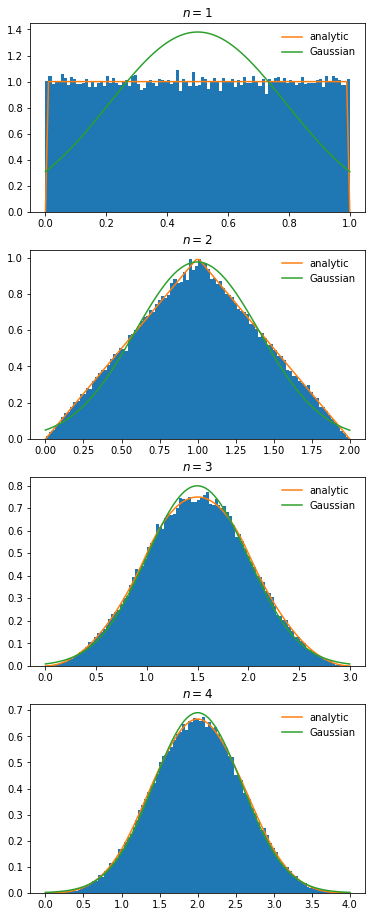

In [24]:
import time

gaussian = lambda x, mu, sigma: np.exp(-(x-mu)**2/2/sigma**2)/sigma/(2*np.pi)**.5
#this is the definition of a gaussian prob. distribution 
#we could have just used a scipy function, but you really should know this (upto normalisation)

N=100
n_max = 4
f,ax = plt.subplots(n_max, 1, figsize=(6,4*n_max))
for n in np.arange(n_max)+1:
    xs = np.linspace(0,n,N)
    
    start = time.time()
    samples = np.sum(np.random.rand(N*1000,n), axis=1) #simulate the process by adding N random numbers
    sampling_time = time.time()-start
    
    start = time.time()
    pdf = [nth_pdf(x,n) for x in xs] #do the n-1 integrals numerically for each x
    integrating_time = time.time() - start
    
    print(f"n={n}, sampling time: {sampling_time:.6f}, integrating time: {integrating_time:.6f}")
    
    ax[n-1].hist(samples, bins=N, density=True)
    ax[n-1].plot(xs, pdf, label="analytic")
    ax[n-1].plot(xs, gaussian(xs, mean(samples), np.std(samples)), label="Gaussian") #gaussian approximation
    ax[n-1].set_title(f"$n={n}$")
    ax[n-1].legend(frameon=False)

We can see that as we increase $n$ the distribution gets more smoothed out, looking more like a Gaussian. Also, we can't numerically integrate beyond $n=4$ with our current integration method (which is inefficient, but would still scale poorly no matter how much we optimised it), while the sampling complexity scales linearly with $n$. This is why, in higher dimensions, Monte Carlo techniques based on sampling are more effective than other numerical techniques. Let's look at a couple of pictures of large $n$.

In [25]:
N = 10000
nbins = 50
n_max = 3
ns = np.logspace(1,n_max,n_max,dtype=int)

f,ax = plt.subplots(n_max, 1, figsize=(6,4*n_max))
for i,n in enumerate(ns):
    samples = np.sum(np.random.rand(N,n), axis=1) #simulate the process by adding N random numbers
    
    counts, edges, patches = ax[i].hist(samples, bins=nbins, density=True)
    ax[i].plot(edges, gaussian(edges, mean(samples), np.std(samples)), label="Gaussian") #gaussian approximation
    ax[i].set_title(f"$n={n}$")
    ax[i].legend(frameon=False)

We see that the Gaussian approximation is good for large $n$. It isn't hard to see where the central limit theorem comes from. Assuming the initial probability distribution has a mean $\mu$ and standard deviation $\sigma$, \begin{align}\langle x\rangle &= \sum_i \langle x_i\rangle = n\mu,\\\langle x^2 \rangle &= \sum_{i,j}\langle x_i x_j \rangle = \sum_i\left(\langle x_i^2\rangle+\sum_{j\not=i}\langle x_i\rangle\langle x_j\rangle\right)=\sum_i\left(\mu^2+\sigma^2+(n-1)\mu^2\right)=n\sigma^2+n^2\mu^2,\\\sigma^2(x)&=\left\langle \big(x-\langle x\rangle\big)^2\right\rangle=\langle x^2\rangle-\langle x\rangle^2=n\sigma^2,\end{align} and so on. Thus, while the mean scales linearly with $n$, the standard deviation scales like $\sqrt{n}$, which means the signal-to-noise ratio scales like ${1}/{\sqrt{n}}$, which is why averaging over larger domains reduces noise. We can test these relations numerically for the uniform distribution (feel free to try another ditribution).

In [26]:
Npoints = 500
ns = np.logspace(1, 4, Npoints, dtype=int)
Nsamples = 50
means = np.zeros(Npoints)
devs = np.zeros(Npoints)

for i in range(Npoints):
    #sum over n uniform randoms Nsamples times to obtain an array of size Nsamples
    samples = np.sum(np.random.rand(Nsamples,ns[i]), axis=1)
    #compute and store its mean and variance
    means[i] = np.mean(samples)
    devs[i] = np.std(samples)
    
plt.plot(ns, means, c="k", label="sample mean")
plt.plot(ns, ns/2, c="k", ls="--")
plt.plot(ns, devs, c="r", label="sample standard deviation")
plt.plot(ns, (ns/12)**0.5, c="r", ls="--")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("$n$")
plt.ylabel("sum of $n$ uniform deviates")
plt.title(f"sample size = {Nsamples}")
plt.legend(frameon=False)

We see extremely good agreement between theory and "experiment". We have now answered the question of how many samples we need to get an estimate of the mean: our error can be estimated by the sample standard deviation divided by $\sqrt{n}$.

<a name="gauss"></a>
### Gaussian distributions

The central limit theorem justifies the ubiquity of Gaussian distributions in statistics and physics. Gaussians are extremely well-studied: we know how to analytically integrate any function over a Gaussian probability distribution. If we are unsure of the form of an unknown distribution, a typical first guess would be that it is Gaussian, usually justified less by the central limit theorem and more by aestheticism. You can sample from the standard normal distribution (a Gaussian with $\mu=0$ and $\sigma=1$) using `numpy.ranom.randn()`(scale and translate the samples to restore non-standard means and variances).

In [27]:
nbins = 100
samples = np.random.randn(nbins*100) #samples from Gaussian
counts, edges, patches = plt.hist(samples, bins=nbins, density=True)
plt.plot(edges, gaussian(edges,0,1))
plt.xlabel("$z$")
plt.ylabel("$p(z)$")

Text(0, 0.5, '$p(z)$')

The cumulative density function of a Gaussian is actually a difficult integral that has no closed form. It is usually evaluated numerically and is known as the [_error function_](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.special.erf.html). In Python, you can find the [error function in `scipy.special`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.special.erf.html), or you can use the `cdf()` method of the `scipy.stats.norm` object.

In [28]:
from scipy.special import erf

x = np.linspace(-5,5,1000)
plt.plot(x, (erf(x/2**.5)+1)/2, label="analytic")
plt.plot(x, [np.sum(samples[:500] <= x0)/500 for x0 in x], label="some samples")
plt.legend(frameon=False)
plt.xlabel("$z$")
plt.ylabel("$p(z'<z)$")

Text(0, 0.5, "$p(z'<z)$")

You might hear experimental results being described as "$n$-$\sigma$". This means that an observed value of some statistic was $n$ times its standard deviation given some hypothesis that is being rejected. Typically results are published at 3 or 5-$\sigma$. If the statistic is normal distributed, this corresponds to the following $p$-values:

In [29]:
from IPython.display import Markdown

n_samples = 10**5
samples = np.random.randn(n_samples)

ns = np.arange(1,6) #which n to compute

#create Markdown table as string
table = "|$n$-$\sigma$|double-tailed $p$-value|fraction in range $=1-p$|number of samples out of range|\n" #header row
table += "|---|---|---|---|\n" #divider row

for n in ns:
    true_p = 1 - erf(n/2**.5) #p(|z|>n) - double-tailed p-value
    sampled = np.sum(np.abs(samples)>n) #number of samples outside range
    table += "|%d-$\sigma$|%.3e|%.4f%%|%d|\n"%(n,true_p,100*(1-true_p),sampled) #add row to table
    
Markdown(table) #output table as Markdown object, will be displayed when returned

|$n$-$\sigma$|double-tailed $p$-value|fraction in range $=1-p$|number of samples out of range|
|---|---|---|---|
|1-$\sigma$|3.173e-01|68.2689%|31333|
|2-$\sigma$|4.550e-02|95.4500%|4487|
|3-$\sigma$|2.700e-03|99.7300%|241|
|4-$\sigma$|6.334e-05|99.9937%|4|
|5-$\sigma$|5.733e-07|99.9999%|0|


The inverse of the error function is useful when computing confidence intervals (you could alternatively use the Gaussian class of `scipy.stats`).

Text(0, 0.5, '$n$-$\\sigma$')

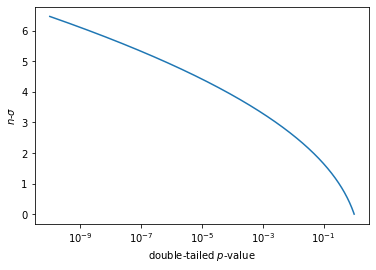

In [30]:
from scipy.special import erfinv

p = np.logspace(-10,0,1000)
plt.plot(p,erfinv(1-p)*2**.5)
plt.xscale("log")
plt.xlabel("double-tailed $p$-value")
plt.ylabel("$n$-$\sigma$")

Now consider the data in `3d_samples.npy`, plotted below. We can use the samples to estimate the covariance using `numpy.cov`.

(3, 10000)


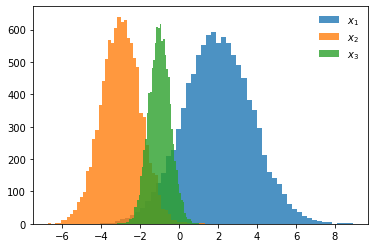

In [31]:
samples = np.load("3d_samples.npy")
print(samples.shape)

nbins = 50

for i in range(3):
    plt.hist(samples[i], nbins, label="$x_%d$"%(i+1), alpha=0.8)
plt.legend(frameon=False)

Each component of the vector is Gaussianly distributed. (This means that any linear combination of the components will also be Gaussian.) Such a distribution is known as a multi-variate Gaussian distribution. Let's plot the first two components together on a 2-d histogram.

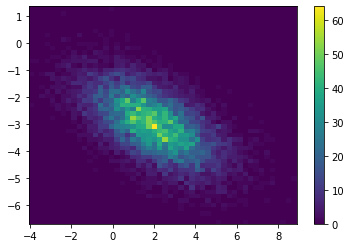

In [32]:
plt.hist2d(*samples[:2], nbins)
plt.colorbar()

We can see that the two components are correlated, i.e. knowledge of one gives knowledge of the other.

The univariate Gaussian is completely characterised by two parameters: its mean and standard deviation. In $d$ dimensions, the multivariate Guassian is completely characterised by its mean $\mu$, a $d$-dimensional vector, and its _covariance matrix_ $C$, a symmetric $d\times d$ matrix defined by $C_{ij}=\langle x_ix_j\rangle - \langle x_i\rangle\langle x_j\rangle$. The variances of each element are the diagonal entries of the covariance matrix. While the terms "correlation" and "covariance" are often used interchangeably in physics, technically the correlation is normalised by the respective standard deviations, i.e. ${\rm corr}_{ij}=\frac{C_{ij}}{\sqrt{C_{ii}C_{jj}}}$, so that correlations are bounded by $\pm 1$, and extreme correlations imply $x_j=\pm x_i$.

We can use our samples to estimate the covariance matrix using `numpy.cov()`. 

In [33]:
mu = np.mean(samples,axis=1)
print(mu)
C = np.cov(samples)
print(C)

[ 1.99177939 -2.99163859 -1.00175914]
[[ 3.0359372  -1.0237001   0.39508898]
 [-1.0237001   1.00690328 -0.30320049]
 [ 0.39508898 -0.30320049  0.30245151]]


If the covariance matrix is invertible, the probability distribution is given by $$p(x)=\frac{\exp\!\left(-\tfrac{1}{2}(x-\mu)^TC^{-1}(x-\mu)\right)}{\sqrt{\det 2\pi C}}.$$ However, particularly in high dimensions, you may find covariance matrices with zero eigenvalues (they cannot be negative if $C=\langle (x-\mu)(x-\mu)^T\rangle$ for real $x$). This must be the case if there are fewer data points than dimensions. In this case, the data is not linearly independent, and you can define a Gaussian pdf on the restriction to the independent components, and multiply with the appropriate delta distributions to describe the complete vector.

We can sample from a given covariance matrix by scaling, rotating and translating independent Gaussian samples. By diagonalising the covariance matrix, i.e. solving for the eigenvalues $\Sigma$ and eigenvectors $V$, $CV=V\Sigma$, with $V^T=V^{-1}$, so $C=V\Sigma V^T$, we find a basis in which the components are independent. The matrix of eigenvectors $V$ is the rotation that goes between these bases, so to sample from a multivariate Gaussian, we must first scale the independent samples by the uncorrelated standard deviations $\sqrt{\Sigma}$, rotate by $V$ to restore correlations, and then translate by adding the mean $\mu$. (You can simplify this by combining the scaling and rotation into a single matrix $V\sqrt{\Sigma}$. Note that you can add any rotation $R$ on the right to simplify the form of the resulting matrix. A convenient choice is to make it lower triangular, $L=V\sqrt{\Sigma}R$, which can be obtained by Cholesky decomposition $C=LL^T$.)

The following cell deaws samples from the measured Gaussian distribution of the data in `2d_samples.npy`.

[ 1.98061863 -2.97885246 -1.00082093]
[[ 2.99892191 -0.99729176  0.38756351]
 [-0.99729176  0.98714975 -0.29660239]
 [ 0.38756351 -0.29660239  0.30113132]]


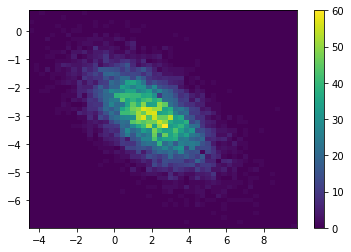

In [34]:
def draw_samples(mu,C,N=1):
    """Draws N samples from multi-variate Gaussian with mean mu covariance matrix C"""
    L = np.linalg.cholesky(C) #find lower-triangular matrix L s.t. C==L.dot(L.T)
    n = len(mu)
    return L.dot(np.random.randn(n,N)) + mu.reshape(n,1)
    
new_samples = draw_samples(mu,C,10000)

plt.hist2d(*new_samples[:2], nbins)
plt.colorbar()

print(np.mean(new_samples,axis=1))
print(np.cov(new_samples)) #check that it's roughly the same

The higher-dimensional analogue of the confidence interval is the _confidence region_, which is defined in the same way as it is for univariate distributions. For example, to compute the 90% confidence region for an arbitrary distribution we would impose a cutoff on the pdf such that the areas with higher probability, which together forms the confidence region, contains 90% probability. For Gaussians, confidence regions are always ellipses, which can be obtained by scaling, rotating and translating a circle similarly to the sampling procedure described in the preceding paragraph. The radius $r$ of the circle depends on the level of confidence $p$ according to $p=\int_0^rdr'\:p(r')$. In $d$ dimensions $$p(r)=\frac{r^{d-1}e^{-\frac{r^2}{2}}}{\Gamma\!\left(\tfrac{d}{2}\right)\sqrt{2^{d-2}}},$$ so $p=\gamma_R\!\left(\tfrac{d}{2},\tfrac{r^2}{2}\right)$, where $\gamma_R$ is the lower [incomplete](http://mathworld.wolfram.com/IncompleteGammaFunction.html) [regularised](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.gammainc.html#scipy.special.gammainc) [Gamma function](http://mathworld.wolfram.com/GammaFunction.html). To compute the scale of a confidence ellipse from a given confidence level, you must thus use the inverse incomplete Gamma function, or consult the table below.

In [35]:
from scipy.special import gammaincinv as ginv

dims = [1,2,3,4,5,10,20,50]
cls = [0.5,0.6827,0.75,0.9,0.99,0.9973,0.9999,0.99999943]

table = "|confidence level|$n$-$\sigma$|d="+"|".join(map(str,dims))+"|\n"
table += "|---|---"+"|---"*len(dims)

for cl in cls:
    table += "|\n|%.4f%%|%.2f"%(100*cl,erfinv(cl)*2**.5)
    for d in dims:
        r = (2*ginv(d/2,cl))**.5
        table += "|%.2f"%r

Markdown(table)

|confidence level|$n$-$\sigma$|d=1|2|3|4|5|10|20|50|
|---|---|---|---|---|---|---|---|---|---|
|50.0000%|0.67|0.67|1.18|1.54|1.83|2.09|3.06|4.40|7.02|
|68.2700%|1.00|1.00|1.52|1.88|2.17|2.43|3.40|4.74|7.36|
|75.0000%|1.15|1.15|1.67|2.03|2.32|2.57|3.54|4.88|7.51|
|90.0000%|1.64|1.64|2.15|2.50|2.79|3.04|4.00|5.33|7.95|
|99.0000%|2.58|2.58|3.03|3.37|3.64|3.88|4.82|6.13|8.73|
|99.7300%|3.00|3.00|3.44|3.76|4.03|4.27|5.19|6.49|9.07|
|99.9900%|3.89|3.89|4.29|4.59|4.85|5.07|5.96|7.24|9.80|
|99.9999%|5.00|5.00|5.36|5.64|5.88|6.09|6.94|8.18|10.70

Note that the radii become larger and more squeezed together in higher dimensions, this is because the volume element grows faster with $r$ in higher dimensions.

You'd be surprised to learn until how recently people used tables like these for common mathematical functions or distributions like logarithms, $\chi^2$s, and Gaussians. Some people are still taught how to use these tables in school! In the past 20 years, digital computing has completely revolutionised the way people have been doing mathematics for thousands of years. If you'd like to learn more, we'd recommend visiting the Computer History Museum in Mountain View.

Let's plot some confidence ellipses corresponding to the first two components using `matplotlib.pacthes.Ellipse`. The covariance matrix marginalised over the other components is simply the relevant covariance sub-matrix. We need to specify the lengths of the axes, which are the uncorrelated standard deviations, and some rotation angle, which is the rotation angle of the eigenvector matrix.

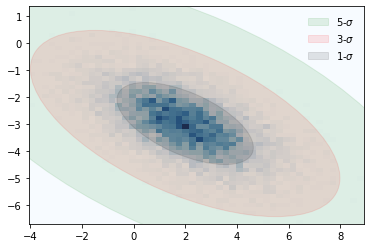

In [36]:
from matplotlib.patches import Ellipse

eigvals,eigvecs = np.linalg.eigh(C[:2,:2])
theta = np.arctan2(eigvecs[1,0],eigvecs[0,0])

plt.hist2d(*samples[:2], nbins, cmap="Blues")
ns = [5,3,1]
cols = "grk"
ells = []
for c,n in zip(cols,ns):
    scale = (2*ginv(1,erf(n/2**.5)))**.5
    e = Ellipse(xy=mu[:2],
                width=2*scale*eigvals[0]**.5,
                height=2*scale*eigvals[1]**.5, 
                angle=theta*180/np.pi,
                color=c,
                alpha=0.1
               )
    plt.gca().add_artist(e)
    ells.append(e)
    cos_angle = np.cos(np.pi-theta)
    sin_angle = np.sin(np.pi-theta)

    xc = samples[0] -mu[0]
    yc = samples[1] -mu[1]

    xct = xc * cos_angle - yc * sin_angle
    yct = xc * sin_angle + yc * cos_angle 

    rad_cc = (xct**2/(e.width/2.)**2) + (yct**2/(e.height/2.)**2)
plt.legend(ells, [r"$%d$-$\sigma$"%n for n in ns], frameon=False)

Since we usually only plot 2-d images, the standard way to visualise higher-dimensional probability distributions is to plot each 2-d and 1-d projection (marginalisation) in a triangle plot. 

In [37]:
def triangle_plot(samples, labels=None, bounds=None, nbins=50, ellipses=[], cols=[], figsize=4, **kwargs):
    n = samples.shape[0]
    if labels is None:
        labels = [""]*n
    if bounds is None:
        bounds = [(np.amin(s), np.amax(s)) for s in samples]
    f,ax = plt.subplots(n,n,gridspec_kw={"hspace": 0.05, "wspace": 0.05},figsize=(4*n,4*n))
    bins = [np.linspace(*bounds[i],nbins+1) for i in range(n)]
    if ellipses:
        mu = np.mean(samples, axis=1)
        C = np.cov(samples)
    for i in range(n):
        ax[i,i].hist(samples[i],bins=bins[i],density=True)
        if i<n-1:
            ax[i,i].set_xticks([])
        ax[i,i].set_yticks([])
        ax[i,i].set_xlim(*bounds[i])
        if ellipses:
            mesh = np.linspace(*bounds[i], 500)
            ax[i,i].plot(mesh, gaussian(mesh, mu[i], C[i,i]**.5))
        for j in range(i):
            if i<n-1:
                ax[i,j].set_xticks([])
            if j>0:
                ax[i,j].set_yticks([])
            ax[i,j].hist2d(samples[j],samples[i], cmap="Blues", bins=[bins[j],bins[i]])
            ax[-(i+1),-(j+1)].axis("off")
            ax[i,j].set_ylim(*bounds[i])
            ax[i,j].set_xlim(*bounds[j])
            ells = []
            if ellipses:
                subcov = C[[[j,j],[i,i]],[[j,i],[j,i]]]
                eigvals,eigvecs = np.linalg.eigh(subcov)
                theta = np.arctan2(eigvecs[1,0],eigvecs[0,0])
                for c,n in zip(cols,ellipses):
                    scale = (2*ginv(1,erf(n/2**.5)))**.5
                    e = Ellipse(xy=mu[[j,i]],
                                width=2*scale*eigvals[0]**.5,
                                height=2*scale*eigvals[1]**.5, 
                                angle=theta*180/np.pi,
                                color=c,
                                alpha = 0.1,
                                **kwargs
                               )
                    ax[i,j].add_artist(e)
                    ells.append(e)
                if i==1:
                    ax[i,j].legend(ells, [r"$%d$-$\sigma$"%n for n in ellipses], frameon=False)
        ax[-1,i].set_xlabel(labels[i])
        if i>0:
            ax[i,0].set_ylabel(labels[i])

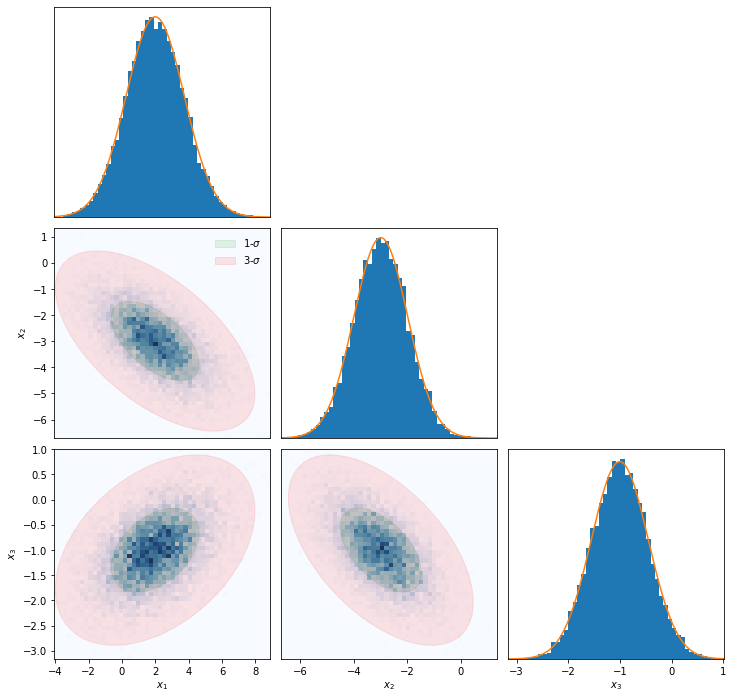

In [38]:
triangle_plot(samples, labels=["$x_%d$"%(i+1) for i in range(3)], ellipses=[1,3], cols="gr")

<a name="bayes"></a>
### Bayesian inference

Two mainstream approaches to statistics are the _frequentist_ and _Bayesian_ schools of thought. The frequentist perspective, similar to the classical physicists' perspective, is that every event has a definite outcome, and statistics well-defined only in the limit of a large number of similar events. The true probability of a specific event or hypothesis is always 0 or 1; we just might not know what it is. Similarly, physical states are well-defined: the universe is is in one specific state, regardless or not of whether we know what that state is. However, in the Bayesian perspective the probability of specific events and hypotheses are well-defined, but subjective. Essentially the probability of an outcome is an observer's degree of belief in it, which can be determined by the odds at which they would flip their bet. According to Bayesians, whether or not the universe is in a specific state, it is effectively in a distribution of states. This difference in viewpoints in statistics is related to the epistemology vs ontology debate in physics, over whether physics describes the true state of the universe or our knowledge of it.

Suppose we have some joint proability distribution $p(x,y)$. We can marginalise over $x$ and $y$ to obtain the lower-dimensional probability distributions $p(x)=\int dy\:p(x,y)$ and $p(y)=\int dx\:p(x,y)$. We can also define the conditional lower-dimensional probabilities $p(x|y)$ and $p(y|x)$ according to $p(x,y) = p(x|y)p(y) = p(y|x)p(x)$. Marginals, e.g. $p(x)$, represent our knowledge when some parameters, e.g. $y$, are unknown, while conditionals, e.g. $p(x|y)$, represent our knowledge when some parameters, e.g. $y$, are known. $x$ and $y$ are indpendent iff $p(x,y)=p(x)p(y)$.

_Bayes' theorem_ is a simple application of the above definitions. Given some data $d$ that might depend on some parameters $\theta$, $$p(\theta|d)=\frac{p(d|\theta)p(\theta)}{p(d)}.$$ This equation describes the procedure of updating an estimate of the parameters $\theta$: we start with $p(\theta)$, called the _prior_, which represents our knowledge of the parameters before acquiring the data $d$. The term $p(d|\theta)$ is called the _likelihood_ of $\theta$, which is what we sometimes can calculate. It describes the probability of observing data $d$ given model $\theta$. The $p(d)$ term is usually ignored since it is independent of $\theta$. When we hold $d$ fixed, as is the case for real data, it is only a normalisation factor which may be estimated numerically or ignored if we only look at likelihood ratios. The updated distribution $p(\theta|d)$ is called the _posterior_ and represents our knowledge including both the prior and the data.

The reason that this is subjective is that this formalism assumes a prior. It is true, however, that observers with the same prior and data will have the same posterior. To get rid of prior prejudice, people try to choose flat, non-informative priors, but this is not reparametrisation-invariant: a flat distirbution will not remain flat under a change of coordinates, so prejudice is implicit in our choice of coordinates. In the limit of large data, any "reasonable" choice of prior should converge to the same result. One may work with the likelihood instead of the posterior (this is equivalent to a flat prior except it may not be restricted to a finite range), but this may not be a normalisable probability distribution (over $\theta$, it is normalised over $d$).

Suppose we had samples that we somehow knew to be Gaussianly distributed, but didn't know the mean or variance. In this case $\theta=(\mu,\sigma)$ and $d$ is a set of $N$ independent samples. Let's start with a flat prior (in a given range), and update on each sample,
$$p(\theta|d)=p(\mu,\sigma|\{x_i\})\propto p(\{x_i\}|\mu,\sigma)=\prod_i \frac{\exp\!\left(-\frac{(x_i-\mu)^2}{2\sigma^2}\right)}{\sqrt{2\pi}\sigma}\propto\sigma^{-N}\exp\!\left(-\sum_i\frac{(x_i-\mu)^2}{2\sigma^2}\right).$$ To avoid underflow, it's common (and arguably more intuitive) to work in log-space.

In [39]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

true_mu = np.random.rand()*10-5
true_sigma = np.random.rand()*4+2

n_samples = 200
n_mesh = 500

samples = np.random.randn(n_samples)*true_sigma + true_mu
mu = np.linspace(-8,8,n_mesh).reshape((1,-1))
sigma = np.linspace(0.5,8,n_mesh).reshape((-1,1))

nll = np.zeros((n_mesh,n_mesh)) #store negative log-likelihood

def update(i,image,title):
    global nll #lazy design (bad practice). see first notebook
    
    s = samples[i] #find i-th sample 
    nll +=  (s-mu)**2/2/sigma**2 + np.log(sigma) #update likelihood
    nll -= np.amin(nll) #set max(likelihood) to 1
    
    image.set_data(np.exp(-nll)) #update plot
    title.set_text("%d sample%s"%(i+1,int(i>0)*"s"))
    return image,title

%matplotlib agg 
#stops it from displaying plots that go into animation
    
fig = plt.figure(figsize=(10,5))
image = plt.imshow(np.exp(-nll), origin="lower", extent=(-8,8,0,8), vmin=0, vmax=1)
plt.scatter(true_mu, true_sigma, marker="x", c="r")
plt.xlabel("mean")
plt.ylabel("standard deviation")
title = plt.title("0 samples")

anim = FuncAnimation(fig, update, len(samples), fargs=(image,title), interval=50, blit=True)

%matplotlib inline
#change settings back to displaying plots inline with cells

HTML(anim.to_jshtml())

A common estimator is the _maximum likelihood_ (ML) estimator, defined by $$\overline\theta_{ML}={\rm argmax}_\theta\: p(d|\theta).$$ When estimating the Gaussian parameters the ML estimator is \begin{align}\overline{\mu}_{ML}&=\frac{1}{N}\sum_ix_i,\\\overline{\sigma}^2_{ML}&=\frac{1}{N}\sum_i\left(x_i-\overline{\mu}_{ML}\right)^2.\end{align} Note that the ML estimate of the standard deviation is biased as it doesn't include Bessel's correction (which is negligible for large $N$).

In many ways the negative log-likelihood is analogous to the action and the ML estimate is analogous to the classical solution for a system. Thus Gaussian likelihoods are analogous to quadratic Hamiltonians. Gaussian likelihoods are a common simplifying assumption, in which case all we need to describe the likelihood completely is the location of its maximum (which is the mean), and the Hessian of the negative log-likelihood (which is the covariance matrix). Typically, the data likelihood depends on more parameters than we care about. These _nuisance parameters_ typically describe the properties of noise and are usually marginalised over. 

<a name="fit2"></a>
### Likelihood fitting

Let us revisit the problem of fitting data to a curve. However, this time let's suppose we have some probability distribution describing the errors in our plot. (In this case stochasticity is injected into a determinstic model by the addition of noise, but we could also start out with a stochastic model.) Thus we can find the expected probability distribution $p(d|\theta)$ of data $d$ given some model $\theta$. This is the likelihood of the model parameters given the observed data, and we can use this to estimate the model parameters, and thus fit the data to a model.

Suppose we have two-dimensional data $x,y$ where we have errors only in $y_i$, described by Gaussians with possibly different widths $\sigma_i$. Then, for a model $y_i=f(x_i,\theta)+\epsilon_i$, where $\epsilon_i\sim\mathcal{N}(0,\sigma_i^2)$, $$-\log p(d|\theta) = \sum_i\frac{\big(y_i-f(x_i,\theta)\big)^2}{2\sigma_i^2}+{\rm constant}.$$ If we only want the best-fit parameters, we can use the ML estimate by specifying, e.g. the negative log-likelihood as our loss function $L(\theta) = -\log p(d|\theta)$. This is equivalent to least squares regression with weights specified by the error estimates! Now we understand the difference between fitting in and out of log-space: we should use coordinates in which the errors are Gaussian. If we have significantly non-Gaussian errors, then least-squares is a poor choice of loss to minimise.

If the model function is linear in the parameters $f(x,\theta)=\sum_n\theta_nf_n(x)$ (e.g. polynomial fitting), then the likelihood of the parameters is Gaussian $-\log p(d|\theta)=\tfrac{1}{2}(\theta-\mu)^TC^{-1}(\theta-\mu)+{\rm constant}$. The best-fit parameters are the mean, $\mu$ and the covariance matrix $C$ tells us the errors on each parameter and the correlations between them. If we define the weighted data vector $v_i = y_i/\sigma_i$, and weighted feature map matrices $F_{ni}=f_n(x_i)/\sigma_i$, then we have $-\log p(d|\theta)=\tfrac{1}{2}(v-F^T\theta)^2+{\rm constant}$, so $C^{-1}=FF^T$ and $\mu=CFv$.

Let's try this out for linear regression on the data in `mystery_array.npy`, we don't know anything about the errors, or even if we have a deterministic model, but let's assume that we have Gaussian errors only on $y$ with $\sigma_i=1$.

In [40]:
d = np.load("mystery_array.npy")

F = np.ones((2,len(d[0]))) #feature maps for linear regression: [[x_i],[1]]
F[0] = d[0]
C = np.linalg.inv(F.dot(F.T))
mu = C.dot(F).dot(d[1])

mu,C

(array([ 1.87683927, -0.62978655]), array([[ 0.00103624, -0.00426129],
        [-0.00426129,  0.0196244 ]]))

For polynomial features, `numpy` has packaged [function](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html)s to do this (and handle cases where $C^{-1}$ is not invertible, which we shall not discuss here).

In [41]:
np.polyfit(*d, 1, cov="unscaled")

(array([ 1.87683927, -0.62978655]), array([[ 0.00103624, -0.00426129],
        [-0.00426129,  0.0196244 ]]))

By eye, the $y$ values seem to Gaussian with a standard deviation of about $\tfrac{1}{3}$. Thus we can specify the weights of $1/\sigma_i$ for the function to use.

The variances of each parameter are the diagonal entries of the covariance matrix, which gives an estimate of the error on each parameter.

In [42]:
mu,C = np.polyfit(*d, 1, cov="unscaled", w=[3]*d.shape[-1])

print("slope = %.3f ± %.3f"%(mu[0],C[0,0]**.5))
print("y-intercept = %.3f ± %.3f"%(mu[1],C[1,1]**.5))

slope = 1.877 ± 0.011
y-intercept = -0.630 ± 0.047


Compare the following plot of the 3-$\sigma$ confidence ellipse of the parameters to the plot of the quadratic loss function (the second plot in the notebook). These plots convey the same information.

(-0.8165693837735848, -0.44300371661795507)

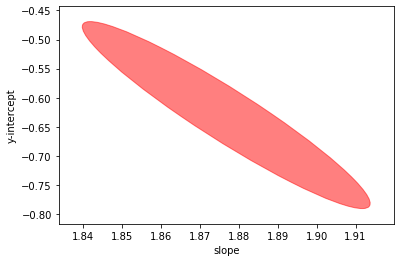

In [43]:
eigvals,eigvecs = np.linalg.eigh(C)
theta = np.arctan2(eigvecs[1,0],eigvecs[0,0])

scale = (2*ginv(1,erf(3/2**.5)))**.5
e = Ellipse(xy=mu,
            width=2*scale*eigvals[0]**.5,
            height=2*scale*eigvals[1]**.5, 
            angle=theta*180/np.pi,
            color="r",
            alpha=0.5
           )
plt.figure()
plt.gca().add_artist(e)
plt.xlabel("slope")
plt.ylabel("y-intercept")
bounds = mu.reshape((2,1)) + np.array([[-1,1]])*np.sqrt(np.diag(C)).reshape(2,1)*4
plt.xlim(*bounds[0])
plt.ylim(*bounds[1])

As a sanity check, we can compare the best-fit $y$ errors with their expected distribution. 

(4.814076308458662e-16, 0.3415459797585369)

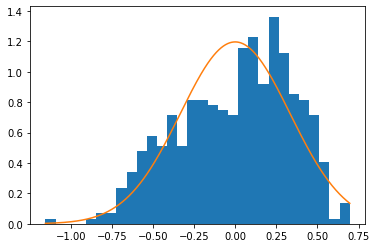

In [44]:
y_pred = [mu[0]*x+mu[1] for x in d[0]]
res = d[1]-y_pred
plt.hist(res, 30, density=True)
mesh = np.linspace(np.amin(res),np.amax(res),1000)
plt.plot(mesh, gaussian(mesh, 0, 1/3))
np.mean(res),np.std(res)

Here's an example of a problem with data points with Gaussian errors of significantly different widths. Providing the appropriate weights has a significant impact on the accuracy of the fit.

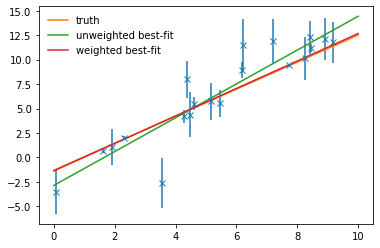

In [45]:
n_samples = 20

true_y0 = np.random.rand()*10-5
true_slope = np.random.rand()*4-2

error = np.random.rand(n_samples)*3
eps = np.random.randn(n_samples)*error

x = np.random.rand(n_samples)*10
y = true_y0 + true_slope*x + eps

x0 = np.array([0,10])

plt.errorbar(x, y, yerr=error, marker="x", ls="")
plt.plot(x0, true_y0+true_slope*x0, label="truth")

unweighted = np.polyfit(x, y, 1)
plt.plot(x0, unweighted[1]+unweighted[0]*x0, label="unweighted best-fit")

weighted = np.polyfit(x, y, 1, w=1/error)
plt.plot(x0, weighted[1]+weighted[0]*x0, label="weighted best-fit")

plt.legend(frameon=False)

If both $x$ and $y$ have error, as is often the case in the real world, then we must marginalise over that error as well, and this can get messy, $$p(d|\theta)=\prod_i\int d\epsilon^x_ip(\epsilon_i^x)\:d\epsilon^y_ip(\epsilon_i^y)\:\delta(y_i-f(x_i+\epsilon^x_i,\theta)-\epsilon^y_i).$$ If the model is linear in the data or the error is small such that $f(x+\epsilon_x,\theta)=f(x,\theta)+\epsilon_x\frac{\partial f(x,\theta)}{\partial x}$, then the total error is $\epsilon = \epsilon_y + \epsilon_x\frac{\partial f(x,\theta)}{\partial x}$. If $\epsilon_x$ and $\epsilon_y$ are Gaussian, then $\epsilon$ is also Gaussian, but even if the model is also linear in the parameters, the likelihood may be non-Gaussian since the effective errors can depend on the parameters.

Let's simplify this in the case of Gaussian errors and linear regression, i.e. when the model is linear in both the data and parameters. Then $f(x,m,y_0)=y_0+mx$, and $\epsilon = \epsilon_y+m\epsilon_x$ is Gaussian with variance $\sigma_y^2+m^2\sigma_x^2$. Thus $$p(y_i|x_i,m,y_0)\propto\frac{1}{\sqrt{\sigma^2(y_i)+m^2\sigma^2(x_i)}}\exp\!\left(-\frac{1}{2}\frac{(y_i-y_0-mx_i)^2}{\sigma^2(y_i)+m^2\sigma^2(x_i)}\right).$$

Let's get some example data.

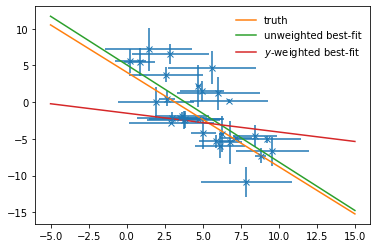

In [46]:
n_samples = 30

true_y0 = np.random.rand()*10-5
true_slope = np.random.rand()*4-2

x_error = np.random.rand(n_samples)*3
y_error = np.random.rand(n_samples)*3
x_eps = np.random.randn(n_samples)*x_error
y_eps = np.random.randn(n_samples)*y_error

x = np.random.rand(n_samples)*10
y = true_y0 + true_slope*(x+x_eps) + y_eps

x0 = np.array([-5,15])

plt.errorbar(x, y, xerr=x_error, yerr=y_error, marker="x", ls="")
plt.plot(x0, true_y0+true_slope*x0, label="truth")

unweighted = np.polyfit(x, y, 1)
plt.plot(x0, unweighted[1]+unweighted[0]*x0, label="unweighted best-fit")

y_weighted = np.polyfit(x, y, 1, w=1/y_error)
plt.plot(x0, y_weighted[1]+y_weighted[0]*x0, label="$y$-weighted best-fit")

plt.legend(frameon=False)

We can see that the usual fitting techniques don't do a great job. Let's explicitly calculate the likelihood. Here's an animation as the likelihood updates on each sample.

In [47]:
n_mesh = 500

slope = np.linspace(-3,3,n_mesh).reshape((1,-1))
y0 = np.linspace(-6,6,n_mesh).reshape((-1,1))

nll = np.zeros((n_mesh,n_mesh)) #store negative log-likelihood

def update(i,image,title):
    global nll
    
    s2 = y_error[i]**2+slope**2*x_error[i]**2
    nll += (y[i]-y0-slope*x[i])**2/2/s2 + np.log(s2)/2 #update likelihood
    nll -= np.amin(nll) #set max(likelihood) to 1
    
    image.set_data(np.exp(-nll)) #update plot
    title.set_text("%d sample%s"%(i+1,int(i>0)*"s"))
    return image,title

%matplotlib agg 
#stops it from displaying plots that go into animation
    
fig = plt.figure(figsize=(5,10))
image = plt.imshow(np.exp(-nll), origin="lower", extent=(-3,3,-6,6), vmin=0, vmax=1)
plt.scatter(true_slope, true_y0, marker="x", c="orange", label="truth")
plt.scatter(*unweighted, marker="x", c="g", label="unweighted least-squares fit")
plt.scatter(*y_weighted, marker="x", c="r", label="$y$-weighted least-squares fit")
plt.xlabel("slope")
plt.ylabel("y-intercept")
title = plt.title("0 samples")
plt.legend()

anim = FuncAnimation(fig, update, n_samples, fargs=(image,title), interval=100, blit=True)

%matplotlib inline
#change settings back to displaying plots inline with cells

HTML(anim.to_jshtml())

We may use an optmisation algorithm to find the maximum likelihood estimate, i.e. the best-fit parameters.

In [48]:
from scipy.optimize import minimize

def fit_nll(a):
    slope,y0 = a
    s2 = y_error**2+slope**2*x_error**2
    return np.sum((y-y0-slope*x)**2/s2 + np.log(s2))/2

res = minimize(fit_nll,(0,0))
res

      fun: 43.31024015625701
 hess_inv: array([[ 0.02024908, -0.10588155],
       [-0.10588155,  0.72559632]])
      jac: array([7.62939453e-06, 2.86102295e-06])
  message: 'Optimization terminated successfully.'
     nfev: 60
      nit: 11
     njev: 15
   status: 0
  success: True
        x: array([-1.29584842,  4.37636466])

We can approximte the likelihood to a Gaussian, in which case the covariance is the inverse Hessian of the negative log-likelihood.

In [49]:
mu = res.x
C = res.hess_inv

print("slope = %.3f ± %.3f"%(mu[0],C[0,0]**.5))
print("y-intercept = %.3f ± %.3f"%(mu[1],C[1,1]**.5))
print("\ntruth:\nslope = %.3f\ny-intercept = %.3f"%(true_slope, true_y0))

slope = -1.296 ± 0.142
y-intercept = 4.376 ± 0.852

truth:
slope = -1.288
y-intercept = 4.093


Instead of simply plotting a best-fit curve, we can sample from the (Gaussian approximation of the) posterior parameter distribution and plot the corresponding curves, thus displaying everything in a single plot.

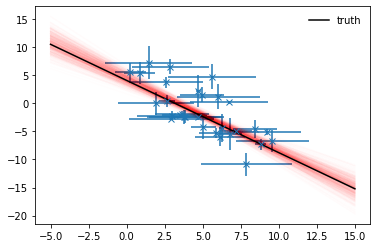

In [50]:
samples = draw_samples(mu,C,500)
plt.errorbar(x, y, xerr=x_error, yerr=y_error, marker="x", ls="")

for s in samples.T:
    plt.plot(x0, s[0]*x0+s[1], c="r", alpha=0.007)
plt.plot(x0, true_y0+true_slope*x0, c="k", label="truth")
plt.legend(frameon=False)

<a name="fisher"></a>
### Fisher information

Fisher information is another way to approach statistics which is useful to quantify the amount of information an observation is expected to contain. A famous result, known as the _Cramer-Rao bound_ states that variance of any (unbiased) estimator of a parameter $\theta$ based on some observable $d$ must be at least than $1/F(\theta)$, where $F(\theta)$ is the amount of Fisher information the observable contains about the $\theta$. An estimator that achieves this bound is known as a _sufficient statistic_, and provides a way to compress data without loss (of information regarding $\theta$). If we find an unbiased estimator with such a variance, we have solved the problem as best possible.

The Fisher information is defined as
$$F(\theta) = \left\langle\left(\frac{\partial \log p(d|\theta)}{\partial \theta}\right)^2\right\rangle=\left\langle-\frac{\partial^2 \log p(d|\theta)}{\partial \theta^2}\right\rangle,$$ where the expectation value is taken over the observations $d$ given the model $\theta$. The Fisher information depends on the "true" value of the parameter, and is similar to the frequentist approach in this regard. In practice Fisher information is used for experimental design, where a _fiducial_ model $\theta$ is considered, or to estimate the errors/confidence intervals on an estimate. 

Fisher information can be understood from a Bayesian perspective as a Gaussian posterior on the parameters, centred around the "true" parameters and with covariance $C=F^{-1}$. Fisher information is additive, so can incorporate a "Bayesian update" (though remember only errors are updated, there are no estimates).

Assuming we have Gaussian data with mean $\mu$ and covariance $C$, $$F(\theta)= \frac{\partial\mu}{\partial\theta}C^{-1}\frac{\partial\mu}{\partial\theta} + \tfrac{1}{2}{\rm tr}\!\left(C\frac{\partial^2C^{-1}}{\partial\theta^2}\right).$$

When there are multiple parameters, the Fisher information is a matrix which is the expected value of the Hessian of the negative log-likelihood of the parameters. The Fisher matrix can also be understood as the Hessian of the relative entropy. In this case sometimes the square root of the determinant of the Fisher matrix is used as a "figure of merit" to quantify multi-variate error as a scalar. This figure of merit is proportional to the inverse volume of the corresponding confidene ellipses. 